# Mosquito

## Stochastic model with temperature dependent parameters

Here, the model is simplified, with only the eggs and adults, where adults can be female, male or sterile male.

Mating rate :$$ \xi(M) = \frac{\alpha M}{1 + \alpha M} .$$

In [29]:
import numpy as np
import matplotlib.pyplot as plt

We can add the temperature modelisation with the time dependant rates.

In [30]:
def temperature(t, offset = 0): # Temperature function in kelvin
    return (4*np.cos(2*np.pi*(t + offset)/365.25 + 9.2) + 28.0) + 273.15

def temperature_const(t,offset = 0): # Constant temperature
    return 273.15 + 28.0

def humidity(t, offset = 0): # Humidity function in percent
    return 60 + 30*np.cos(6*np.pi*(t + offset)/365.25 + 9.2) + 10*np.cos(8*np.pi*(t + offset)/365.25 + 9.2)

In [31]:
#plot the humidity on a year
def plot_humidity():
    t = np.linspace(0, 365, 366)
    plt.plot(t, humidity(t), label='Humidity (%)')
    plt.xlabel('Day of the year')
    plt.ylabel('Humidity (%)')
    plt.title('Humidity over a year')
    plt.grid()
    plt.legend()
    plt.show()
    
#plot the temperature on a year
def plot_temperature():
    t = np.linspace(0, 365, 366)
    plt.plot(t, temperature(t), label='Temperature (K)')
    plt.xlabel('Day of the year')
    plt.ylabel('Temperature (K)')
    plt.title('Temperature over a year')
    plt.grid()
    plt.legend()
    plt.show()

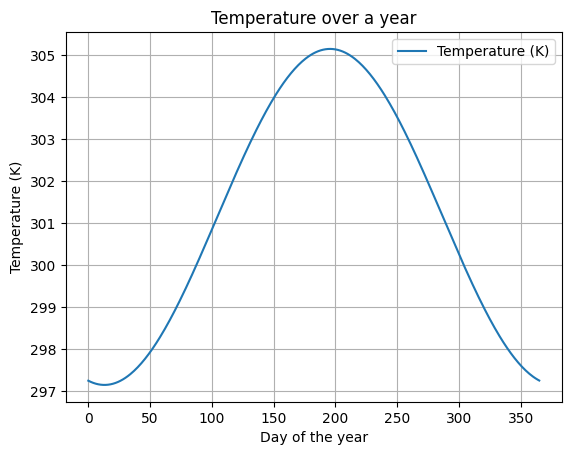

In [32]:
plot_temperature()

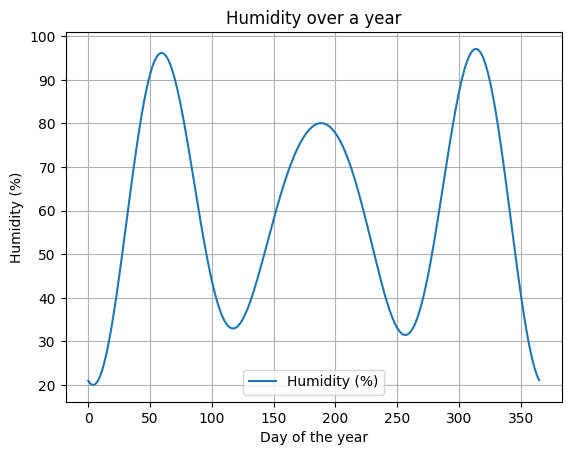

In [33]:
plot_humidity()

In [34]:
def transition_rate(evt, T, R0, Ha, Hh, T12, R): # Transition rate function from one state to another
    return R0[evt]*(T/298)*np.exp(Ha[evt]*(1/298 - 1/T)/R)/(1 + np.exp(Hh[evt]*(1/T12[evt] - 1/T)/R))

def adult_rate(T, R0, Ha, Hh, T12, R): # Transition rate function from larvae to pupae to adult
    egg_transi = transition_rate(0, T, R0, Ha, Hh, T12, R)
    larvae_transi = transition_rate(1, T, R0, Ha, Hh, T12, R)
    pupae_transi = transition_rate(2, T, R0, Ha, Hh, T12, R)
    death_L = 0.01 + 0.9725*np.exp(-0.1*(T - 278)/2.7035)
    death_P = 0.01 + 0.9725*np.exp(-0.1*(T - 278)/2.7035)

    return egg_transi*larvae_transi*pupae_transi/((pupae_transi + death_P) * (larvae_transi + death_L))

def competition(K0, Kh, Hum, Hum0):
    return min(100, 1/(K0 + Kh *  (Hum - Hum0)))

In [35]:
# definition of the different mortality rates : 
def egg_death(T) : 
    if T < 288 : 
        return 0
    else :
        return 0.011 # A calculer

In [36]:
def mating(M, Ms):
    return  M / (1 + M + Ms)

def event(i, state, M_event):
    return state + M_event[i]

def release1(M, n):
    return n*M + 1000

def release2(M, n):
    return 0

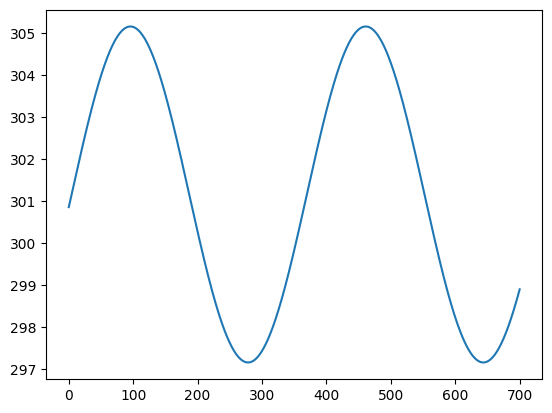

In [37]:
#print temperature over a year
time = np.linspace(0, 700, 2000)
temp = temperature(time,100)
plt.plot(time, temp)

In [38]:
# Parameters
birth = 0.5  # Birth rate per adult
puberty = 0.83      # transition rate from egg to adult
mu = 0.5    # rate at which egg becomes a female
#egg_death = 0.2     # Death rate per egg
adult_death = 0.091  # Death rate per adult
sterile_death = adult_death*1.2   # Death rate per sterile
init_egg = 10  # Starting egg population
init_f0 = 100 # Starting female population
init_ff = 0 # Starting fertilised female pop
init_fs = 0 # Starting strerile female pop
init_male = 100 # Starting adult population
init_sterile = 0 # Starting sterile male population
max_time = 500.0     # Maximum simulation time
comp_egg = 0.0001 # Carrying capacity 
n_rel = 0

R0 = [0.24, 0.2088, 0.384]
Hh = [100, 55.99, -472.379]
Ha = [10.798, 26.018, 14.931]
T12 = [14.184, 304.6, 148]
R = 8.31446261815324 # Universal gas constant
# Initialize variables

sterile_hist = 0
t = 0
time_history = [t]
pop = np.array([init_egg, init_f0, init_ff, init_fs, init_male, init_sterile], dtype=int)
population_history = [(pop[0], pop[1], pop[2], pop[3], pop[4], pop[5])]
Mat_events = np.array([[30, -1, 0, 0],
              [-1, 0, 0, 0],
              [0,-1, 0, 0],
              [0, 0, -1, 0],
              [-1, 1, 0, 0],
              [-1, 0, 1, 0],
              [0, 0, 0, -1]], dtype=np.int8)

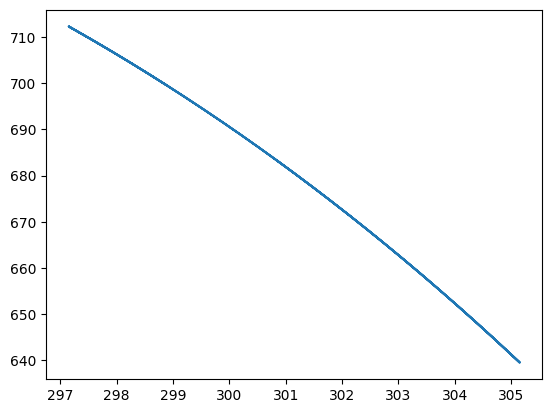

In [39]:
stability = []
for i in temp:
    egg_adult_rate = adult_rate(i, R0, Ha, Hh, T12, R)
    stability.append((egg_death(i) + comp_egg * pop[0] + (transition_rate(0, i, R0, Ha, Hh, T12, R) - egg_adult_rate) - birth*mu*egg_adult_rate/adult_death)/comp_egg)

plt.plot(temp,stability)

In [40]:
def plot_com_evo():
    t = np.linspace(0, 365, 366)
    plt.plot(t, [competition(1/comp_egg, 1/(comp_egg * 50), humidity(day), 60) for day in t], label='Compétition (K)')
    plt.xlabel('Day of the year')
    plt.ylabel('Compétition (K)')
    plt.title('Compétition over a year')
    plt.grid()
    plt.legend()
    plt.show()

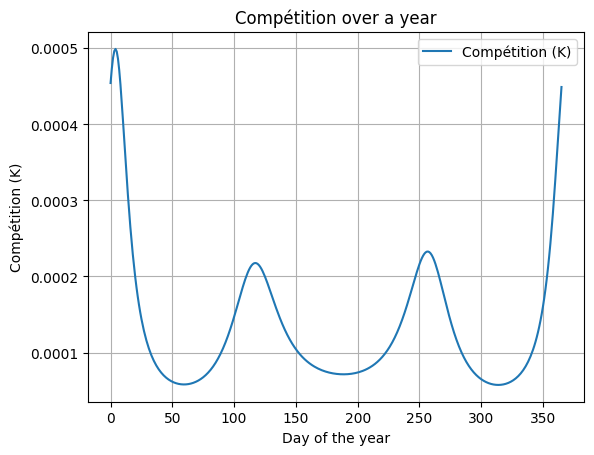

In [41]:
plot_com_evo()

In [42]:
while t < 365*2:
    # Step 1: Calculate total rate
    T = temperature(t)
    #T = temperature_const(t)  # Uncomment this line to use constant temperature
    Hum = 60
    egg_adult_rate = adult_rate(T, R0, Ha, Hh, T12, R)
    comp = competition(1/comp_egg, 1/(comp_egg * 100), Hum, 60)
    if T < 286:
        death_egg = 0.001
        egg_adult_rate = 0
        adult_death = 1.5*adult_death
    else :    
        death_egg = egg_death(T) + comp * pop[0] + (transition_rate(0, T, R0, Ha, Hh, T12, R) - egg_adult_rate)
        adult_death = 0.091
    
    prob_M = pop[4]/(pop[4] + pop[5])
    prob_Ms = pop[5]/(pop[4] + pop[5])

    total_rate = ( birth * pop[2] +
        (death_egg) * pop[0]+
        adult_death *(pop[1] + pop[2] + pop[3] + pop[4]) +
        mu * egg_adult_rate * pop[0] +
        (1 - mu) * egg_adult_rate * pop[0] +
        sterile_death * pop[5] +  
        mating(0.01*pop[4], 0.001*pop[5]) * prob_M * pop[1] +
        mating(0.001*pop[5], 0.01*pop[4]) * prob_Ms * pop[1])
    
    if total_rate == 0:
        print("No life :(")
        break

    # Step 2: Draw time to next event
    time_to_next_event = np.random.exponential(1 / total_rate)
    t += time_to_next_event

    # Step 4: Determine the event
    p = np.random.rand()

    if p < (birth * pop[2]) / total_rate:
        pop[0] += 63
    elif p < (egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
        pop[0] -= 1
        pop[1] += 1
    elif p < (egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
        pop[0] -= 1
        pop[4] += 1
    elif p < (death_egg * pop[0] + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
        pop[0] -= 1
    elif p < (adult_death * pop[1] + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
        pop[1] -= 1
    elif p < (adult_death * (pop[1] + pop[2]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
        pop[2] -= 1
    elif p < (adult_death * (pop[1] + pop[2] + pop[3]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
        pop[3] -= 1
    elif p < (adult_death * (pop[1] + pop[2] + pop[3] + pop[4]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
        pop[4] -= 1
    elif p < (sterile_death * pop[5] + adult_death * (pop[1] + pop[2] + pop[3] + pop[4]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
        pop[5] -= 1
    elif p < (mating(0.01*pop[4], 0.001*pop[5])* prob_M * pop[1] + sterile_death * pop[5] + adult_death * (pop[1] + pop[2] + pop[3] + pop[4]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
        pop[1] -= 1
        pop[2] +=1
    else :
        pop[1] -= 1
        pop[3] += 1

    # Step 3: Sterile insect release
    if int(t) % 7 == 0 and (len(time_history) == 0 or int(time_history[-1]) != int(t))  and pop[2] > 30 and t > 450 and n_rel < 8 and 3 == 4:
        pop[5] += release1(pop[4], 100)
        n_rel += 1
        print("Release no", n_rel, "at time", t, "of", release1(pop[4], 100), "sterile insects")

    # Step 5: Record history
    time_history.append(t)
    population_history.append((pop[0], pop[1], pop[2], pop[3], pop[4], pop[5]))
    if sum(pop) == 0 or pop[4] + pop[5] == 0:
        print("No life :(")
        break
    
    if min(pop) < 0:
        print("Negative population :(")
        break


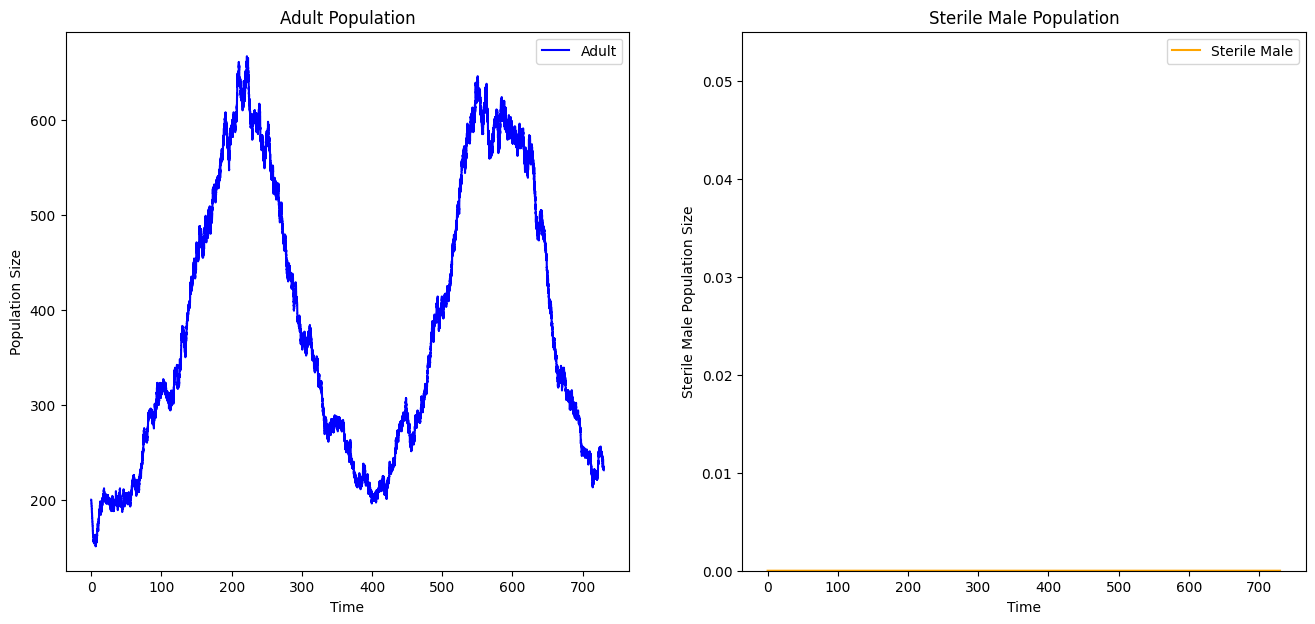

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
temp = temperature(np.array(time_history), 100)
# Plot results for male and female population
axs[0].step(time_history, [pop[1]+ pop[2] + pop[3] + pop[4] for pop in population_history], where="post", label='Adult', color = 'blue')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Population Size')
axs[0].set_title('Adult Population')
axs[0].legend()

# Plot results for sterile male population
axs[1].step(time_history, [pop[5] for pop in population_history], where="post", label='Sterile Male', color='orange')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Sterile Male Population Size')
axs[1].set_ylim(bottom=0)
axs[1].set_title('Sterile Male Population')
axs[1].legend()

/tmp/ipykernel_138892/1825315722.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


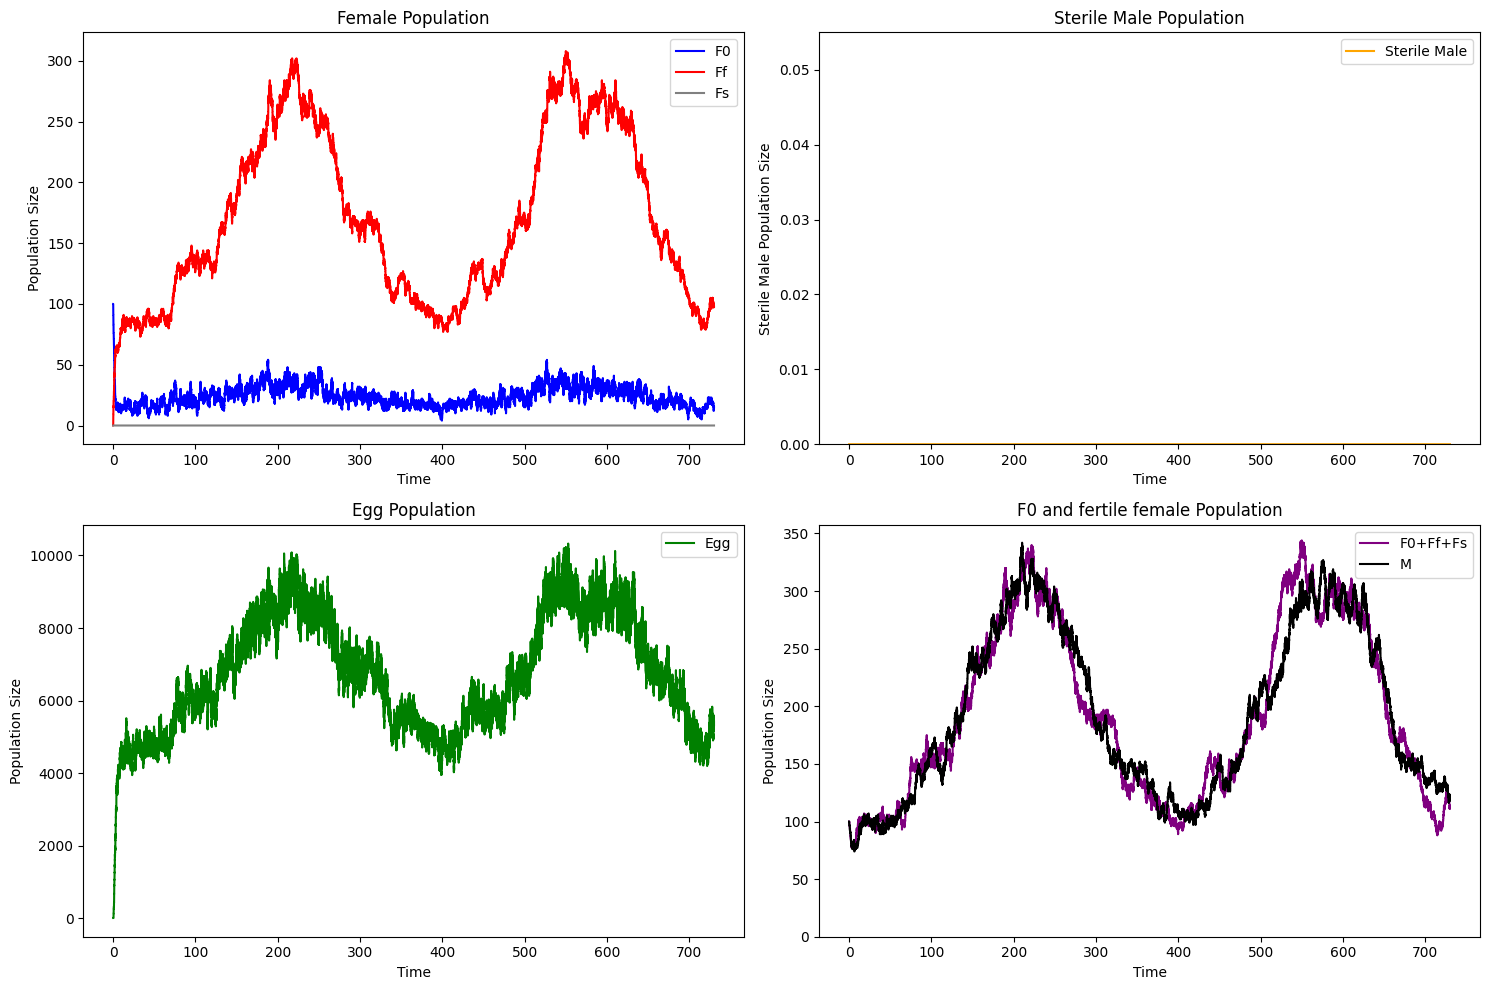

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(time_history), 100)
# Plot results for male and female population
axs[0, 0].step(time_history, [pop[1] for pop in population_history], where="post", label='F0', color = 'blue')
axs[0, 0].step(time_history, [pop[2] for pop in population_history], where="post", label='Ff', color = 'red')
axs[0, 0].step(time_history, [pop[3] for pop in population_history], where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(time_history, [pop[5] for pop in population_history], where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(time_history, [pop[0] for pop in population_history], where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(time_history, [pop[1] + pop[2] + pop[3] for pop in population_history], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(time_history, [pop[4] for pop in population_history], where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


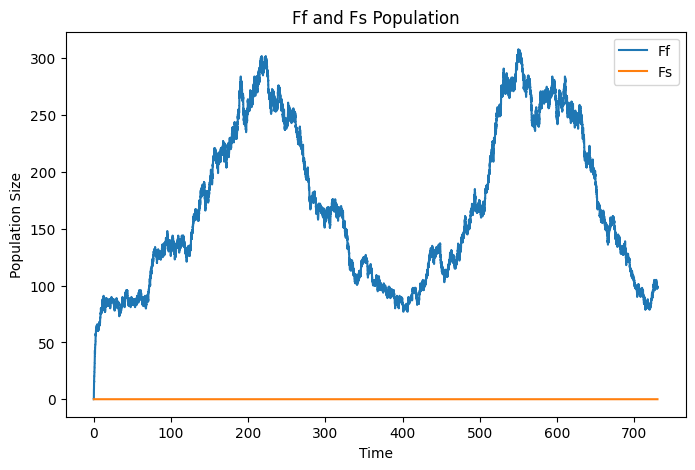

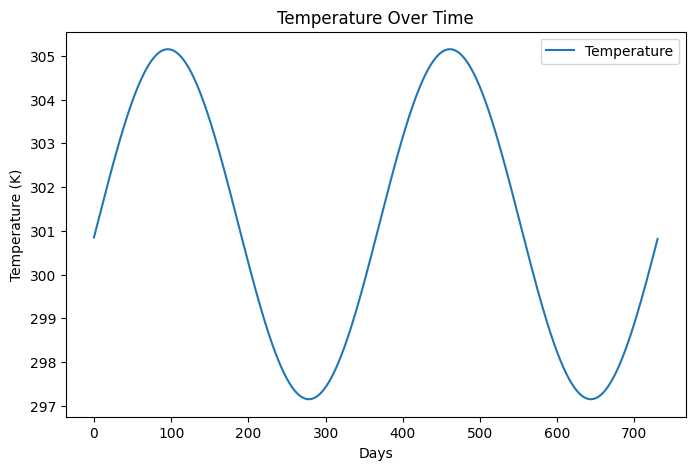

In [47]:

# Plot results for male and female population
axs[2, 0].step(time_history, [pop[2] for pop in population_history], where="post", label='Ff')
axs[2, 0].step(time_history, [pop[3] for pop in population_history], where="post", label='Fs')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('Population Size')
axs[2, 0].set_title('Ff and Fs Population')
axs[2, 0].legend()


# Plot temperature over time
axs[2, 1].plot(time_history, temp, label='Temperature')
axs[2, 1].set_xlabel('Days')
axs[2, 1].set_ylabel('Temperature (K)')
axs[2, 1].set_title('Temperature Over Time')
axs[2, 1].legend()


In [48]:
population_history[-1]

(np.int64(5324),
 np.int64(15),
 np.int64(98),
 np.int64(0),
 np.int64(118),
 np.int64(0))

## Small population

A close to extinction pop is taken during release.

In [ ]:
# Parameters
birth = 0.5  # Birth rate per adult
puberty = 0.83      # transition rate from egg to adult
mu = 0.5    # rate at which egg becomes a female
egg_death = 0.2     # Death rate per egg
adult_death = 0.091  # Death rate per adult
sterile_death = adult_death * 0.1   # Death rate per sterile
init_egg = 1000  # Starting egg population
init_female = 500 # Starting female population
init_male = 500 # Starting adult population
init_sterile = 0 # Starting sterile male population
max_time = 500.0     # Maximum simulation time
comp_egg = 0.000001 # Carrying capacity

R0 = [0.24, 0.2088, 0.384]
Hh = [100, 55.99, -472.379]
Ha = [10.798, 26.018, 14.931]
T12 = [14.184, 304.6, 148]
R = 8.31446261815324 # Universal gas constant
# Initialize variables

sterile_hist = 0
t = 0
time_history = [t]
pop = np.array([init_egg, init_female, init_male, init_sterile], dtype=int)
population_history = [(pop[0], pop[1], pop[2], pop[3])]
Mat_events = np.array([[30, -1, 0, 0],
              [-1, 0, 0, 0],
              [0,-1, 0, 0],
              [0, 0, -1, 0],
              [-1, 1, 0, 0],
              [-1, 0, 1, 0],
              [0, 0, 0, -1]], dtype=np.int8)

In [ ]:
while t < 365*5 : #and (pop[0] + pop[2] + pop[1] > 0):
    # Step 1: Calculate total rate
    T = temperature(t, 100)
    #T = 295.5
    egg_adult_rate = adult_rate(T, R0, Ha, Hh, T12, R)
    
    if T < 286:
        death_egg = 0.001
        egg_adult_rate = 0
    else :    
        death_egg = egg_death(T) + comp_egg * pop[0] + (transition_rate(0, T, R0, Ha, Hh, T12, R) - egg_adult_rate)
    
    total_rate = (
        birth * mating(pop[2], pop[3]) * pop[1] +
        death_egg * pop[0]+
        adult_death *(pop[1] + pop[2]) +
        mu * egg_adult_rate * pop[0] +
        (1 - mu) * egg_adult_rate * pop[0] +
        sterile_death * pop[3]
    )
    
    if total_rate == 0:
        print("No life :(")
        break

    # Step 2: Draw time to next event
    time_to_next_event = np.random.exponential(1 / total_rate)
    t += time_to_next_event


    # Step 4: Determine the event
    p = np.random.rand()

    if p < (birth * mating(pop[2], pop[3]) * pop[1]) / total_rate:
        pop[0] += 63
    elif p < (egg_adult_rate * mu * pop[0] + birth * mating(pop[2], pop[3]) * pop[1]) / total_rate and pop[0] > 0:
        pop[0] -= 1
        pop[1] += 1
    elif p < (egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * mating(pop[2], pop[3]) * pop[1]) / total_rate and pop[0] > 0:
        pop[0] -= 1
        pop[4] += 1
    elif p < (death_egg * pop[0] + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * mating(pop[2], pop[3]) * pop[1]) / total_rate and pop[0] > 0:
        pop[0] -= 1
    elif p < (adult_death * pop[1]*0.5 + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * mating(pop[2], pop[3]) * pop[1]) / total_rate:
        pop[1] -= 1
    elif p < (adult_death * (pop[1]*0.5 + pop[2]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * mating(pop[2], pop[3]) * pop[1]) / total_rate:
        pop[2] -= 1
    elif p < (adult_death * (pop[1]*0.5 + pop[2]+ pop[3]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * mating(pop[2], pop[3]) * pop[1]) / total_rate:
        pop[3] -= 1
    elif  < (adult_death * (pop[1]*0.5 + pop[2]+ pop[3]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * mating(pop[2], pop[3]) * pop[1]) / total_rate:

    # Step 3: Sterile insect release
    if int(t) % 7 == 0 and (len(time_history) == 0 or int(time_history[-1]) != int(t))  and pop[1] > 30:
        pop[3] += release1(pop[2], 100)

    # Step 5: Record history
    time_history.append(t)
    population_history.append((pop[0], pop[1], pop[2], pop[3]))

In [ ]:
# Plot results for male, female, and egg population
plt.figure(figsize=(10, 6))
plt.step(time_history, [pop[0] for pop in population_history], where="post", label='Egg')
plt.step(time_history, [pop[1] for pop in population_history], where="post", label='Male')
plt.step(time_history, [pop[2] for pop in population_history], where="post", label='Female')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Egg, Male, Female)')
plt.ylim(0, 200)
plt.legend()
plt.show()

# Plot results for sterile male population
plt.figure(figsize=(10, 6))
plt.step(time_history, [pop[3] for pop in population_history], where="post", label='Sterile Male')
plt.xlabel('Time')
plt.ylabel('Sterile Male Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Sterile Male)')
plt.legend()
plt.show()

## Benchmarking the models ?

In [ ]:
import time

t = 0.0
step1_durations = []
step2_durations = []
step3_durations = []
step4_durations = []
step5_durations = []

while t < 100 and (pop[1] + pop[2] > 0):
    # Étape 1 : Calcul du taux total
    start_step1 = time.time()
    rate_matrix = np.array([
        birth * mating(pop[2], pop[3]) * pop[1],
        (egg_death + comp_egg * (pop[0] - 1)) * pop[0],
        adult_death * pop[1],
        adult_death * pop[2],
        mu * puberty * pop[0],
        (1 - mu) * puberty * pop[0],
        sterile_death * pop[3]
    ], dtype=float)
    total_rate = np.sum(rate_matrix)
    end_step1 = time.time()
    step1_durations.append(end_step1 - start_step1)

    # Étape 2 : Dessiner le temps jusqu'au prochain événement
    start_step2 = time.time()
    time_to_next_event = np.random.exponential(1 / total_rate)
    t += time_to_next_event
    end_step2 = time.time()
    step2_durations.append(end_step2 - start_step2)

    # Étape 3 : Relâchement des insectes stériles
    start_step3 = time.time()
    if (
        int(t) % 7 == 0
        and (len(time_history) == 0 or int(time_history[-1]) != int(t))
        and t > 40
    ):
        new_release = release1(pop[2], 20)
        pop[3] += new_release
        sterile_hist += new_release
    end_step3 = time.time()
    step3_durations.append(end_step3 - start_step3)

    # Étape 4 : Evenement
    start_step4 = time.time()
    cumulative_probabilities = np.cumsum(rate_matrix / total_rate)

    # Draw a random number
    r = np.random.rand()

    # Find the event using binary search
    n_event = np.searchsorted(cumulative_probabilities, r,side = 'left')
    pop = np.add(pop, Mat_events[n_event])
    end_step4 = time.time()
    step4_durations.append(end_step4 - start_step4)

    # Étape 5 : Enregistrement de l'historique
    start_step5 = time.time()
    time_history.append(t)
    population_history.append(pop)
    end_step5 = time.time()
    step5_durations.append(end_step5 - start_step5)

# Résultats : Durées totales et moyennes pour chaque étape
num_iterations = len(time_history)

total_time_step1 = sum(step1_durations)
total_time_step2 = sum(step2_durations)
total_time_step3 = sum(step3_durations)
total_time_step4 = sum(step4_durations)
total_time_step5 = sum(step5_durations)

avg_time_step1 = total_time_step1 / num_iterations
avg_time_step2 = total_time_step2 / num_iterations
avg_time_step3 = total_time_step3 / num_iterations
avg_time_step4 = total_time_step4 / num_iterations
avg_time_step5 = total_time_step5 / num_iterations

print(f"Step 1 (Rate calculation) - Total: {total_time_step1:.6f}s, Average: {avg_time_step1:.6f}s")
print(f"Step 2 (Time to next event) - Total: {total_time_step2:.6f}s, Average: {avg_time_step2:.6f}s")
print(f"Step 3 (Sterile release) - Total: {total_time_step3:.6f}s, Average: {avg_time_step3:.6f}s")
print(f"Step 4 (Determine event) - Total: {total_time_step4:.6f}s, Average: {avg_time_step4:.6f}s")
print(f"Step 5 (Record history) - Total: {total_time_step5:.6f}s, Average: {avg_time_step5:.6f}s")
print("len(time_history): ", len(time_history))
# Graphiques des populations
plt.figure(figsize=(10, 6))
plt.step(time_history, [k[0] for k in population_history], where="post", label='Egg')
plt.step(time_history, [k[1] for k in population_history], where="post", label='Female')
plt.step(time_history, [k[2] for k in population_history], where="post", label='Male')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Egg, Male, Female)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.step(time_history, [k[3] for k in population_history], where="post", label='Sterile Male')
plt.xlabel('Time')
plt.ylabel('Sterile Male Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Sterile Male)')
plt.legend()
plt.show()

print("Total sterile insects released: ", sterile_hist)

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Assumptions: `mating()`, `release1()`, and all other required parameters (e.g., `birth`, `K`, `egg_death`) are defined.
# Parameters
birth = 0.5  # Birth rate per adult
puberty = 0.8      # transition rate from egg to adult
mu = 0.5    # rate at which egg becomes a female
egg_death = 0.2     # Death rate per egg
adult_death = 0.2     # Death rate per adult
sterile_death = 0.3   # Death rate per sterile
init_egg = 0  # Starting egg population
init_female = 100 # Starting female population
init_male = 5 # Starting adult population
init_sterile = 0 # Starting sterile male population
max_time = 500.0     # Maximum simulation time
comp_egg = 1/500 # Carrying capacity

# Initialize variables
pop[0] = init_egg
pop[2] = init_male
pop[1] = init_female
pop[3] = init_sterile
sterile_hist = 0
t = 0.0
time_history = [t]
pop = np.array([pop[0], pop[1], pop[2], pop[3]], dtype=int)
population_history = [(pop[0], pop[1], pop[2], pop[3])]
Mat_events = np.array([[30, -1, 0, 0],
              [-1, 0, 0, 0],
              [0,-1, 0, 0],
              [0, 0, -1, 0],
              [-1, 1, 0, 0],
              [-1, 0, 1, 0],
              [0, 0, 0, -1]], dtype=np.int8)

# Timing for each step
step1_durations = []  # Total rate calculation
step2_durations = []  # Time to next event
step3_durations = []  # Sterile insect release
step4_durations = []  # Event determination
step5_durations = []  # Record history

while t < max_time and (pop[0] + pop[2] + pop[1] > 0):
    # Step 1: Calculate total rate
    start_step1 = time.time()
    total_rate = (
        birth * mating(pop[2], pop[3]) * pop[1] +
        (egg_death + comp_egg * pop[0]) * pop[0]+
        adult_death * pop[2] +
        adult_death * pop[1] +
        mu * puberty * pop[0] +
        (1 - mu) * puberty * pop[0] +
        sterile_death * pop[3]
    )
    end_step1 = time.time()
    step1_durations.append(end_step1 - start_step1)

    # Step 2: Draw time to next event
    start_step2 = time.time()
    time_to_next_event = np.random.exponential(1 / total_rate)
    t += time_to_next_event
    end_step2 = time.time()
    step2_durations.append(end_step2 - start_step2)


    # Step 4: Determine the event
    start_step4 = time.time()
    p = np.random.rand()

    if p < (birth * mating(pop[2], pop[3]) * pop[1]) / total_rate:
        pop[0] += 30
        pop[1] -= 1
    elif p < (puberty * mu * pop[0] + birth * mating(pop[2], pop[3]) * pop[1]) / total_rate and pop[0] > 0:
        pop[0] -= 1
        pop[1] += 1
    elif p < (puberty * (1 - mu) * pop[0] + puberty * mu * pop[0] + birth * mating(pop[2], pop[3]) * pop[1]) / total_rate and pop[0] > 0:
        pop[0] -= 1
        pop[2] += 1
    elif p < ((egg_death + comp_egg * pop[0]) * pop[0] + puberty * (1 - mu) * pop[0] + puberty * mu * pop[0] + birth * mating(pop[2], pop[3]) * pop[1]) / total_rate and pop[0] > 0:
        pop[0] -= 1
    elif p < (adult_death * pop[1] + (egg_death + comp_egg * pop[0]) * pop[0]  + puberty * (1 - mu) * pop[0] + puberty * mu * pop[0] + birth * mating(pop[2], pop[3]) * pop[1]) / total_rate:
        pop[1] -= 1
    elif p < (adult_death * (pop[1] + pop[2]) + (egg_death + comp_egg * pop[0]) * pop[0]  + puberty * (1 - mu) * pop[0] + puberty * mu * pop[0] + birth  * mating(pop[2], pop[3]) * pop[1]) / total_rate:
        pop[2] -= 1
    else:
        pop[3] -= 1
    end_step4 = time.time()
    step4_durations.append(end_step4 - start_step4)

    # Step 3: Sterile insect release
    start_step3 = time.time()
    if int(t) % 7 == 0 and (len(time_history) == 0 or int(time_history[-1]) != int(t)) and t > 40:
        pop[3] += release1(pop[2], 100)
    end_step3 = time.time()
    step3_durations.append(end_step3 - start_step3)

    # Step 5: Record history
    start_step5 = time.time()
    time_history.append(t)
    population_history.append((pop[0], pop[2], pop[1], pop[3]))
    end_step5 = time.time()
    step5_durations.append(end_step5 - start_step5)

# Calculate total and average durations for each step
num_iterations = len(time_history)

total_time_step1 = sum(step1_durations)
total_time_step2 = sum(step2_durations)
total_time_step3 = sum(step3_durations)
total_time_step4 = sum(step4_durations)
total_time_step5 = sum(step5_durations)

avg_time_step1 = total_time_step1 / num_iterations
avg_time_step2 = total_time_step2 / num_iterations
avg_time_step3 = total_time_step3 / num_iterations
avg_time_step4 = total_time_step4 / num_iterations
avg_time_step5 = total_time_step5 / num_iterations

# Print the results
print(f"Step 1 (Rate calculation) - Total: {total_time_step1:.6f}s, Average: {avg_time_step1:.6f}s")
print(f"Step 2 (Time to next event) - Total: {total_time_step2:.6f}s, Average: {avg_time_step2:.6f}s")
print(f"Step 3 (Sterile release) - Total: {total_time_step3:.6f}s, Average: {avg_time_step3:.6f}s")
print(f"Step 4 (Determine event) - Total: {total_time_step4:.6f}s, Average: {avg_time_step4:.6f}s")
print(f"Step 5 (Record history) - Total: {total_time_step5:.6f}s, Average: {avg_time_step5:.6f}s")
print("len(time_history): ", len(time_history))

# Plot results for male, female, and egg population
plt.figure(figsize=(10, 6))
plt.step(time_history, [pop[0] for pop in population_history], where="post", label='Egg')
plt.step(time_history, [pop[1] for pop in population_history], where="post", label='Male')
plt.step(time_history, [pop[2] for pop in population_history], where="post", label='Female')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Egg, Male, Female)')
plt.legend()
plt.show()

# Plot results for sterile male population
plt.figure(figsize=(10, 6))
plt.step(time_history, [pop[3] for pop in population_history], where="post", label='Sterile Male')
plt.xlabel('Time')
plt.ylabel('Sterile Male Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Sterile Male)')
plt.legend()
plt.show()


In [ ]:

print("len(time_history): ", len(time_history))

## Altenative model

In [ ]:
# Simulation loop
while time < max_time and ( pop[1] + pop[2] > 0):

    # Total rate for any event to happen (birth or death)
    rate_matrix = np.array([birth * mating(pop[2], pop[3]) * pop[1], 
                   (egg_death + comp_egg * pop[0]) * pop[0], 
                   adult_death * pop[1],
                   adult_death * pop[2], 
                   mu * puberty * pop[0], 
                   (1-mu) * puberty * pop[0], 
                   sterile_death * pop[3]])
    
 #    total_rate = birth * mating(pop[2], pop[3]) * pop[1] + (egg_death + comp_egg * pop[0]) * pop[0] + adult_death * pop[2] + adult_death * pop[1] + mu * puberty * pop[0] + (1-mu) * puberty * pop[0] + sterile_death * pop[3]
    total_rate = sum(rate_matrix)

    # Draw the time to the next event from an exponential distribution
    time_to_next_event = np.random.exponential(1 / total_rate)
    time += time_to_next_event
    # Release sterile insects
    if int(time) % 7 == 0 and (len(time_history) == 0 or int(time_history[-1]) != int(time)) and time > 40:
        new_release = release1(pop[2], 50)
        pop[3] += new_release
        sterile_hist += new_release

    # Determine the event that will happen
    n_event = np.random.choice(range(7), p=np.array(rate_matrix)/total_rate)
    
    pop += Mat_events[n_event]

    # Record time and population
    time_history.append(time)
    population_history.append(pop)

# Plot results for male, female, and egg population
plt.figure(figsize=(10, 6))
plt.step(time_history, [k[0] for k in population_history], where="post", label='Egg')
plt.step(time_history, [k[1] for k in population_history], where="post", label='Female')
plt.step(time_history, [k[2] for k in population_history], where="post", label='Male')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Egg, Male, Female)')
plt.legend()
plt.show()

# Plot results for sterile male population
plt.figure(figsize=(10, 6))
plt.step(time_history, [k[3] for k in population_history], where="post", label='Sterile Male')
plt.xlabel('Time')
plt.ylabel('Sterile Male Population Size')
plt.title('Continuous-Time Birth-Death Process Simulation (Sterile Male)')
plt.legend()
plt.show()

print("Total sterile insects released: ", sterile_hist)